# Decision Tree Ensemble Starter Kit for Kaggle House Prices 

## Imports and inits

In [38]:
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator 
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch 
h2o.init() # give h2o as much memory as possible
h2o.no_progress() # turn off h2o progress bars

import numpy as np
import pandas as pd

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_112"; Java(TM) SE Runtime Environment (build 1.8.0_112-b16); Java HotSpot(TM) 64-Bit Server VM (build 25.112-b16, mixed mode)
  Starting server from /Users/phall/anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmplt34f54i
  JVM stdout: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmplt34f54i/h2o_phall_started_from_python.out
  JVM stderr: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmplt34f54i/h2o_phall_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster version:,3.12.0.1
H2O cluster version age:,4 days
H2O cluster name:,H2O_from_python_phall_pbwv49
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


## Import data

In [39]:
train = h2o.import_file('../data/train.csv')
test = h2o.import_file('../data/test.csv')

# bug fix - from Keston
dummy_col = np.random.rand(test.shape[0])
test = test.cbind(h2o.H2OFrame(dummy_col))
cols = test.columns
cols[-1] = 'SalePrice'
test.columns = cols
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 81)


#### Determine data types

In [40]:
def get_type_lists(frame=train, rejects=['Id', 'SalePrice']):

    """Creates lists of numeric and categorical variables.
    
    :param frame: The frame from which to determine types.
    :param rejects: Variable names not to be included in returned lists.
    :return: Tuple of lists for numeric and categorical variables in the frame.
    
    """
    
    nums, cats = [], []
    for key, val in frame.types.items():
        if key not in rejects:
            if val == 'enum':
                cats.append(key)
            else: 
                nums.append(key)
                
    print('Numeric =', nums)                
    print()
    print('Categorical =', cats)
    
    return nums, cats

In [41]:
original_nums, cats = get_type_lists()

Numeric = ['OpenPorchSF', 'MasVnrArea', 'GarageYrBlt', 'BsmtHalfBath', 'WoodDeckSF', 'FullBath', 'BsmtFinSF1', 'OverallQual', 'LowQualFinSF', 'MiscVal', 'GrLivArea', 'GarageArea', 'MSSubClass', '2ndFlrSF', 'YearBuilt', 'HalfBath', 'TotRmsAbvGrd', 'BsmtUnfSF', 'PoolArea', 'LotFrontage', 'MoSold', 'YearRemodAdd', 'EnclosedPorch', 'TotalBsmtSF', 'KitchenAbvGr', 'LotArea', 'YrSold', 'OverallCond', 'BedroomAbvGr', 'Fireplaces', 'ScreenPorch', '1stFlrSF', 'GarageCars', '3SsnPorch', 'BsmtFinSF2', 'BsmtFullBath']

Categorical = ['Condition1', 'Heating', 'Electrical', 'RoofStyle', 'Functional', 'Utilities', 'SaleCondition', 'LotShape', 'ExterCond', 'GarageCond', 'MasVnrType', 'BsmtFinType1', 'HeatingQC', 'BsmtCond', 'MSZoning', 'CentralAir', 'BsmtFinType2', 'Exterior2nd', 'BsmtQual', 'Condition2', 'KitchenQual', 'RoofMatl', 'Foundation', 'Fence', 'HouseStyle', 'SaleType', 'Exterior1st', 'GarageQual', 'BldgType', 'Alley', 'Neighborhood', 'LandSlope', 'ExterQual', 'GarageFinish', 'FireplaceQu', '

## Split into to train and validation (before doing data prep!!!)

In [42]:
train, valid = train.split_frame([0.7], seed=12345)
print(train.shape)
print(valid.shape)

(1001, 81)
(459, 81)


## Impute numeric missing

In [43]:
# median usually better than mean
# (_ signifies temporary throw-away variable, used to suppress output)
_ = train[['MasVnrArea', 'GarageYrBlt', 'LotFrontage']].impute(method='median')
_ = valid[['MasVnrArea', 'GarageYrBlt', 'LotFrontage']].impute(method='median')
_ = test[['BsmtHalfBath', 'BsmtFinSF1', 'BsmtFullBath', 'BsmtFinSF2', 'BsmtUnfSF', 'MasVnrArea', 
          'GarageYrBlt', 'LotFrontage', 'GarageCars', 'TotalBsmtSF', 'GarageArea']].impute(method='median')

## Encode categorical vars using shrunken averages
http://helios.mm.di.uoa.gr/~rouvas/ssi/sigkdd/sigkdd.vol3.1/barreca.ps

In [44]:
def target_encoder(training_frame, test_frame, x, y, lambda_=0.15, threshold=150, test=False):

    """ Applies simple target encoding to categorical variables.

    :param training_frame: Training frame which to create target means and to be encoded.
    :param test_frame: Test frame to be encoded using information from training frame.
    :param x: Name of input variable to be encoded.
    :param y: Name of target variable to use for encoding.
    :param lambda_: Balance between level mean and overall mean for small groups.
    :param threshold: Number below which a level is considered small enough to be shrunken.
    :param test: Whether or not to print the row_val_dict for testing purposes.
    :return: Tuple of encoded variable from train and test set as H2OFrames.

    """

    # convert to pandas
    trdf = training_frame.as_data_frame().loc[:, [x,y]] # df
    tss = test_frame.as_data_frame().loc[:, x]          # series


    # create dictionary of level:encode val

    encode_name = x + '_Tencode'
    overall_mean = trdf[y].mean()
    row_val_dict = {}

    for level in trdf[x].unique():
        level_df = trdf[trdf[x] == level][y]
        level_n = level_df.shape[0]
        level_mean = level_df.mean()
        if level_n >= threshold:
            row_val_dict[level] = level_mean
        else:
            row_val_dict[level] = ((1 - lambda_) * level_mean) +\
                                  (lambda_ * overall_mean)

    row_val_dict[np.nan] = overall_mean # handle missing values

    if test:
        print(row_val_dict)

    # apply the transform to training data
    trdf[encode_name] = trdf[x].apply(lambda i: row_val_dict[i])

    # apply the transform to test data
    tsdf = pd.DataFrame(columns=[x, encode_name])
    tsdf[x] = tss
    tsdf.loc[:, encode_name] = overall_mean # handle previously unseen values
    # handle values that are seen in tsdf but not row_val_dict
    for i, col_i in enumerate(tsdf[x]):
        try:
            row_val_dict[col_i]
        except:
            # a value that appeared in tsdf isn't in the row_val_dict so just
            # make it the overall_mean
            row_val_dict[col_i] = overall_mean
    tsdf[encode_name] = tsdf[x].apply(lambda i: row_val_dict[i])


    # convert back to H2O

    trdf = h2o.H2OFrame(trdf[encode_name].as_matrix())
    trdf.columns = [encode_name]

    tsdf = h2o.H2OFrame(tsdf[encode_name].as_matrix())
    tsdf.columns = [encode_name]

    return (trdf, tsdf)


#### Execute encoding

In [45]:
total = len(cats)
for i, var in enumerate(cats):
    
    tr_enc, _ = target_encoder(train, test, var, 'SalePrice')
    v_enc, ts_enc = target_encoder(valid, test, var, 'SalePrice')
    
    print('Encoding: ' + var + ' (' + str(i+1) + '/' + str(total) + ') ...')

    train = train.cbind(tr_enc)
    valid = valid.cbind(v_enc)
    test = test.cbind(ts_enc)    
    
print('Done.')

Encoding: Condition1 (1/43) ...
Encoding: Heating (2/43) ...
Encoding: Electrical (3/43) ...
Encoding: RoofStyle (4/43) ...
Encoding: Functional (5/43) ...
Encoding: Utilities (6/43) ...
Encoding: SaleCondition (7/43) ...
Encoding: LotShape (8/43) ...
Encoding: ExterCond (9/43) ...
Encoding: GarageCond (10/43) ...
Encoding: MasVnrType (11/43) ...
Encoding: BsmtFinType1 (12/43) ...
Encoding: HeatingQC (13/43) ...
Encoding: BsmtCond (14/43) ...
Encoding: MSZoning (15/43) ...
Encoding: CentralAir (16/43) ...
Encoding: BsmtFinType2 (17/43) ...
Encoding: Exterior2nd (18/43) ...
Encoding: BsmtQual (19/43) ...
Encoding: Condition2 (20/43) ...
Encoding: KitchenQual (21/43) ...
Encoding: RoofMatl (22/43) ...
Encoding: Foundation (23/43) ...
Encoding: Fence (24/43) ...
Encoding: HouseStyle (25/43) ...
Encoding: SaleType (26/43) ...
Encoding: Exterior1st (27/43) ...
Encoding: GarageQual (28/43) ...
Encoding: BldgType (29/43) ...
Encoding: Alley (30/43) ...
Encoding: Neighborhood (31/43) ...
Encod

#### Redefine numerics and explore

In [46]:
encoded_nums, cats = get_type_lists(frame=train)

Numeric = ['MiscFeature_Tencode', 'LotShape_Tencode', 'SaleType_Tencode', 'HeatingQC_Tencode', 'BsmtFinType1_Tencode', '3SsnPorch', 'Exterior2nd_Tencode', 'OpenPorchSF', 'MasVnrArea', 'Foundation_Tencode', 'Alley_Tencode', 'Street_Tencode', 'Heating_Tencode', 'GarageYrBlt', 'GarageCond_Tencode', 'BsmtHalfBath', 'BsmtCond_Tencode', 'WoodDeckSF', 'FireplaceQu_Tencode', 'CentralAir_Tencode', 'FullBath', 'Electrical_Tencode', 'PoolQC_Tencode', 'BsmtFinSF1', 'LandSlope_Tencode', 'OverallQual', 'LotConfig_Tencode', 'BsmtFinType2_Tencode', 'Fence_Tencode', 'TotRmsAbvGrd', 'MiscVal', 'RoofMatl_Tencode', 'LowQualFinSF', 'GarageArea', 'BsmtQual_Tencode', 'MSSubClass', 'HouseStyle_Tencode', 'LandContour_Tencode', 'YearBuilt', 'HalfBath', 'ExterQual_Tencode', 'RoofStyle_Tencode', 'Functional_Tencode', 'BsmtFinSF2', 'BsmtExposure_Tencode', 'BsmtUnfSF', 'MasVnrType_Tencode', 'PoolArea', 'LotFrontage', '2ndFlrSF', 'YearRemodAdd', 'GarageType_Tencode', 'Neighborhood_Tencode', 'MoSold', 'TotalBsmtSF', 

In [47]:
print('Imputed and encoded numeric training data:')
train[encoded_nums].describe() #79 numeric columns w/ no missing
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric validation data:')
valid[encoded_nums].describe() #79 numeric columns w/ no missing
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric test data:')
test[encoded_nums].describe() #79 numeric columns w/ no missing

Imputed and encoded numeric training data:
Rows:1001
Cols:79




,MiscFeature_Tencode,LotShape_Tencode,SaleType_Tencode,HeatingQC_Tencode,BsmtFinType1_Tencode,3SsnPorch,Exterior2nd_Tencode,OpenPorchSF,MasVnrArea,Foundation_Tencode,Alley_Tencode,Street_Tencode,Heating_Tencode,GarageYrBlt,GarageCond_Tencode,BsmtHalfBath,BsmtCond_Tencode,WoodDeckSF,FireplaceQu_Tencode,CentralAir_Tencode,FullBath,Electrical_Tencode,PoolQC_Tencode,BsmtFinSF1,LandSlope_Tencode,OverallQual,LotConfig_Tencode,BsmtFinType2_Tencode,Fence_Tencode,TotRmsAbvGrd,MiscVal,RoofMatl_Tencode,LowQualFinSF,GarageArea,BsmtQual_Tencode,MSSubClass,HouseStyle_Tencode,LandContour_Tencode,YearBuilt,HalfBath,ExterQual_Tencode,RoofStyle_Tencode,Functional_Tencode,BsmtFinSF2,BsmtExposure_Tencode,BsmtUnfSF,MasVnrType_Tencode,PoolArea,LotFrontage,2ndFlrSF,YearRemodAdd,GarageType_Tencode,Neighborhood_Tencode,MoSold,TotalBsmtSF,GarageFinish_Tencode,KitchenQual_Tencode,SaleCondition_Tencode,Utilities_Tencode,KitchenAbvGr,LotArea,YrSold,OverallCond,ExterCond_Tencode,MSZoning_Tencode,BedroomAbvGr,EnclosedPorch,Fireplaces,PavedDrive_Tencode,GrLivArea,ScreenPorch,Exterior1st_Tencode,1stFlrSF,GarageCars,BldgType_Tencode,GarageQual_Tencode,Condition1_Tencode,BsmtFullBath,Condition2_Tencode
type,real,real,real,real,real,int,real,int,real,real,real,real,real,real,real,int,real,int,real,real,int,real,real,int,real,int,real,real,real,int,int,real,int,int,real,int,real,real,int,int,real,real,real,int,real,int,real,int,real,int,int,real,real,int,int,real,real,real,real,int,int,int,int,real,real,int,int,int,real,int,int,real,int,int,real,real,real,int,real
mins,140375.79385614386,163944.59385614382,125968.29385614385,135668.69902855766,150410.4464877228,0.0,129978.23968947721,0.0,0.0,121726.89385614387,128075.200999001,146350.10385614386,93469.96052281052,1908.0,112070.79385614385,0.0,84275.79385614385,0.0,141462.34885614386,119608.23368665231,0.0,84275.79385614385,182171.95904095902,0.0,181486.5182747485,2.0,176473.2899159664,154536.9355228105,141306.73814185814,3.0,0.0,143775.79385614386,0.0,0.0,121216.12093947716,20.0,118907.22242757239,145140.16285614387,1875.0,0.0,116078.96885614384,161577.2224275724,110059.12718947718,0.0,167645.4123076923,0.0,155578.6188811189,0.0,21.0,0.0,1950.0,125174.9605228105,109690.79385614385,1.0,0.0,141354.57177033494,124936.94820396995,115832.04385614385,144200.79385614386,0.0,1300.0,2006.0,2.0,122047.14941169939,78614.79385614385,0.0,0.0,0.0,129253.89464979463,480.0,0.0,78325.79385614385,480.0,0.0,138273.46052281052,96813.29385614385,134468.29385614386,0.0,108075.79385614385
mean,181198.19224147475,181993.92786324563,181180.3311701286,182409.7085632649,185645.79515235015,3.4565434565434567,183994.52609268852,44.92407592407592,106.91146881287727,183119.90242260235,180171.38546862727,182203.5349842964,182323.57985955098,1978.734522560336,186002.74671607107,0.059940059940059943,184043.11900766566,91.07392607392607,200266.80114860163,182822.70708043204,1.5744255744255744,182952.64128239392,182802.82568320786,445.5994005994006,182145.0556687069,6.1448551448551445,181772.16118142597,184056.75787594018,177450.87030976015,6.512487512487512,39.684315684315685,182033.94005549894,5.9250749250749255,477.46853146853147,182245.41278741238,57.08791208791209,183188.25635258848,182186.73299732237,1972.2987012987012,0.38161838161838163,181095.69602749898,182159.0086938536,182576.24533688094,41.64935064935065,182844.62529074325,575.99000999001,180574.40004970055,3.3766233766233764,70.59975669099758,341.7872127872128,1985.138861138861,185255.62265751234,182171.95904095905,6.362637362637362,1063.2387612387613,185712.8721618042,180810.97023994988,181541.32494458588,182178.65314071544,1.046953046953047,10628.262737262738,2007.828171828172,5.583416583416583,182637.23505924645,183387.92640181992,2.871128871128871,21.257742257742258,0.6203796203796204,182908.18055950044,1519.8011988011988,14.763236763236764,183565.71379414792,1172.0889110889111,1.7932067932067932,182849.79797600003,186018.3297154893,182645.11776425372,0.42657342657342656,182224.44

--------------------------------------------------------------------------------
Imputed and encoded numeric validation data:
Rows:459
Cols:79




,MiscFeature_Tencode,LotShape_Tencode,SaleType_Tencode,HeatingQC_Tencode,BsmtFinType1_Tencode,3SsnPorch,Exterior2nd_Tencode,OpenPorchSF,MasVnrArea,Foundation_Tencode,Alley_Tencode,Street_Tencode,Heating_Tencode,GarageYrBlt,GarageCond_Tencode,BsmtHalfBath,BsmtCond_Tencode,WoodDeckSF,FireplaceQu_Tencode,CentralAir_Tencode,FullBath,Electrical_Tencode,PoolQC_Tencode,BsmtFinSF1,LandSlope_Tencode,OverallQual,LotConfig_Tencode,BsmtFinType2_Tencode,Fence_Tencode,TotRmsAbvGrd,MiscVal,RoofMatl_Tencode,LowQualFinSF,GarageArea,BsmtQual_Tencode,MSSubClass,HouseStyle_Tencode,LandContour_Tencode,YearBuilt,HalfBath,ExterQual_Tencode,RoofStyle_Tencode,Functional_Tencode,BsmtFinSF2,BsmtExposure_Tencode,BsmtUnfSF,MasVnrType_Tencode,PoolArea,LotFrontage,2ndFlrSF,YearRemodAdd,GarageType_Tencode,Neighborhood_Tencode,MoSold,TotalBsmtSF,GarageFinish_Tencode,KitchenQual_Tencode,SaleCondition_Tencode,Utilities_Tencode,KitchenAbvGr,LotArea,YrSold,OverallCond,ExterCond_Tencode,MSZoning_Tencode,BedroomAbvGr,EnclosedPorch,Fireplaces,PavedDrive_Tencode,GrLivArea,ScreenPorch,Exterior1st_Tencode,1stFlrSF,GarageCars,BldgType_Tencode,GarageQual_Tencode,Condition1_Tencode,BsmtFullBath,Condition2_Tencode
type,real,real,real,real,real,int,real,int,real,real,real,real,real,real,real,int,real,int,real,real,int,real,real,int,real,int,real,real,real,int,int,real,int,int,real,int,real,real,int,int,real,real,real,int,real,int,real,int,real,int,int,real,real,int,int,real,real,real,real,int,int,int,int,real,real,int,int,int,real,int,int,real,int,int,real,real,real,int,real
mins,73479.02450980392,163981.4191419142,107734.02450980392,100679.02450980392,146338.19117647054,0.0,106204.02450980392,0.0,0.0,110363.31736694675,134607.54723707662,95579.02450980392,77729.02450980392,1900.0,118776.94117647059,0.0,78579.02450980392,0.0,133191.52450980392,111601.52450980392,0.0,100143.52450980392,178193.4967320261,0.0,175531.83179723503,1.0,165751.57330498463,145091.52450980392,133419.96200980392,2.0,0.0,175904.02450980392,0.0,0.0,134771.7517825312,20.0,122402.59593837534,163075.56297134238,1872.0,0.0,91042.14950980392,139864.02450980392,84954.02450980392,0.0,161376.63366336632,0.0,131576.52450980392,0.0,21.0,0.0,1950.0,111434.07450980392,112866.7168174962,1.0,0.0,143948.79679144386,105130.89950980392,143816.52450980392,178193.4967320261,1.0,1491.0,2006.0,1.0,91754.02450980392,118217.35784313723,0.0,0.0,0.0,114840.96895424835,334.0,0.0,96429.02450980392,334.0,0.0,128987.56617647059,134853.20367647058,150223.0311764706,0.0,84954.02450980392
mean,177409.66351972884,176786.22238241704,177239.63702422145,180663.6615169379,180031.30962236744,3.30718954248366,179728.60882139349,50.446623093681914,96.68340611353712,179041.90369302404,176164.9969256838,178225.25931265755,178371.04867785895,1977.9953051643192,184432.0126553889,0.05228758169934641,180413.2355397497,101.15904139433552,194587.7731541999,179115.18492887347,1.5446623093681917,179083.62772865137,178198.69396030012,439.36601307189545,177815.9926203597,6.0,178163.26637404418,180587.69974155238,173941.1787702735,6.529411764705882,51.78649237472767,177969.71943483275,5.668845315904139,463.1917211328976,179069.59942970652,56.48148148148148,177648.76674783204,177854.22806185653,1969.0196078431372,0.38562091503267976,174940.2994916485,177381.1458157119,178425.73264556366,57.23529411764706,178366.110436157,548.1590413943355,176108.20460862629,1.411764705882353,68.85751978891821,358.3442265795207,1984.2701525054467,185134.53079371178,178193.49673202613,6.233115468409586,1044.7603485838779,181122.03431372548,177298.2844312017,177335.48292323467,178193.49673202608,1.0457516339869282,10273.808278867102,2007.7886710239652,5.557734204793029,178484.55631381093,179328.32668845312,2.8562091503267975,23.47276688453159,0.5969498910675382,179002.9605814003,1506.004357298475,15.710239651416122,179651.10523303002,1141.9912854030501,1.710239651416122,178649.14910504507,184195.2038275876,178617.62590029472,0.4226579520697168,178197.18104147978
maxs,188229.0

--------------------------------------------------------------------------------
Imputed and encoded numeric test data:
Rows:1459
Cols:79




,MiscFeature_Tencode,LotShape_Tencode,SaleType_Tencode,HeatingQC_Tencode,BsmtFinType1_Tencode,3SsnPorch,Exterior2nd_Tencode,OpenPorchSF,MasVnrArea,Foundation_Tencode,Alley_Tencode,Street_Tencode,Heating_Tencode,GarageYrBlt,GarageCond_Tencode,BsmtHalfBath,BsmtCond_Tencode,WoodDeckSF,FireplaceQu_Tencode,CentralAir_Tencode,FullBath,Electrical_Tencode,PoolQC_Tencode,BsmtFinSF1,LandSlope_Tencode,OverallQual,LotConfig_Tencode,BsmtFinType2_Tencode,Fence_Tencode,TotRmsAbvGrd,MiscVal,RoofMatl_Tencode,LowQualFinSF,GarageArea,BsmtQual_Tencode,MSSubClass,HouseStyle_Tencode,LandContour_Tencode,YearBuilt,HalfBath,ExterQual_Tencode,RoofStyle_Tencode,Functional_Tencode,BsmtFinSF2,BsmtExposure_Tencode,BsmtUnfSF,MasVnrType_Tencode,PoolArea,LotFrontage,2ndFlrSF,YearRemodAdd,GarageType_Tencode,Neighborhood_Tencode,MoSold,TotalBsmtSF,GarageFinish_Tencode,KitchenQual_Tencode,SaleCondition_Tencode,Utilities_Tencode,KitchenAbvGr,LotArea,YrSold,OverallCond,ExterCond_Tencode,MSZoning_Tencode,BedroomAbvGr,EnclosedPorch,Fireplaces,PavedDrive_Tencode,GrLivArea,ScreenPorch,Exterior1st_Tencode,1stFlrSF,GarageCars,BldgType_Tencode,GarageQual_Tencode,Condition1_Tencode,BsmtFullBath,Condition2_Tencode
type,real,real,real,real,real,int,real,int,real,real,real,real,real,real,real,real,real,int,real,real,int,real,real,real,real,int,real,real,real,int,int,real,int,real,real,int,real,real,int,int,real,real,real,real,real,real,real,int,real,int,int,real,real,int,real,real,real,real,real,int,int,int,int,real,real,int,int,int,real,int,int,real,int,real,real,real,real,real,real
mins,73479.02450980392,163981.4191419142,107734.02450980392,100679.02450980392,146338.19117647054,0.0,106204.02450980392,0.0,0.0,110363.31736694675,134607.54723707662,95579.02450980392,77729.02450980392,1895.0,118776.94117647059,0.0,78579.02450980392,0.0,133191.52450980392,111601.52450980392,0.0,100143.52450980392,178193.4967320261,0.0,175531.83179723503,1.0,165751.57330498463,145091.52450980392,133419.96200980392,3.0,0.0,175904.02450980392,0.0,0.0,134771.7517825312,20.0,122402.59593837534,163075.56297134238,1879.0,0.0,91042.14950980392,139864.02450980392,84954.02450980392,0.0,161376.63366336632,0.0,131576.52450980392,0.0,21.0,0.0,1950.0,111434.07450980392,112866.7168174962,1.0,0.0,143948.79679144386,105130.89950980392,143816.52450980392,178193.4967320261,0.0,1470.0,2006.0,1.0,91754.02450980392,118217.35784313723,0.0,0.0,0.0,114840.96895424835,407.0,0.0,96429.02450980392,407.0,0.0,128987.56617647059,134853.20367647058,150223.0311764706,0.0,127029.02450980392
mean,177606.24421888925,176844.0836371834,175933.10715345875,182227.81273899964,182091.99147253158,1.794379712131597,180995.23531825157,48.3139136394791,100.70914127423823,181006.2901857593,176172.85149770897,178065.09267032953,179140.34833949362,1977.7212165097756,184620.93755108098,0.06520247083047358,179283.61725237884,93.17477724468814,194452.82035270397,179789.60281035837,1.570938999314599,180126.1193152811,178193.4967320261,439.2037037037037,177395.21920765378,6.078821110349555,178278.00897433652,180689.57815766838,174246.9783571091,6.385195339273475,58.16792323509253,176751.75320615337,3.5435229609321452,472.7688614540466,181062.10689687656,57.37834132967786,176296.0327526845,179174.226337526,1971.357779300891,0.3776559287183002,177673.68837649448,177370.7037166422,178383.03720943845,52.61934156378601,179354.8610184363,554.2949245541838,178207.07986924512,1.7443454420836186,68.58035714285714,325.9677861549006,1983.6627827278958,186339.7089378328,179660.9318538107,6.104180945853324,1046.1179698216736,180987.1789957136,179340.3962464452,176492.09637795313,178193.4967320261,1.0424948594928032,9819.161069225496,2007.7697052775875,5.5538039753255655,178138.29247727426,179232.09043019178,2.8540095956134337,24.24331734064427,0.5812200137080192,177090.15440559445,1486.0459218642907,17.064427690198766,179810.686881209,1156.534612748458,1.7661179698216736,178370.36965515942,182567.66333366183,179939.77372747526,0.4344543582704186,178369.3998087

In [48]:
# Check Neighborhood_Tencode

print(test[0:5, ['Neighborhood', 'Neighborhood_Tencode']])
_, _ = target_encoder(valid, test, 'Neighborhood', 'SalePrice', test=True)
del _

# NAmes   152080
# NAmes   152080
# Gilbert 191808
# Gilbert 191808
# StoneBr 288359

Neighborhood,Neighborhood_Tencode
NAmes,152080
NAmes,152080
Gilbert,191808
Gilbert,191808
StoneBr,288359



{nan: 178193.49673202613, 'Somerst': 227656.9671023965, 'BrkSide': 129965.77450980392, 'NPkVill': 147641.52450980392, 'Sawyer': 143162.40700980392, 'Gilbert': 191808.0596949891, 'SWISU': 156269.02450980392, 'OldTown': 139863.03613771088, 'Blmngtn': 210845.6545098039, 'ClearCr': 207949.02450980392, 'Mitchel': 169316.52450980392, 'StoneBr': 288359.0245098039, 'NAmes': 152080.32258672698, 'Edwards': 126241.13989441929, 'NoRidge': 273948.2552790347, 'NridgHt': 284073.1545098039, 'NWAmes': 184610.14950980392, 'Veenker': 243734.02450980392, 'CollgCr': 190019.77971813726, 'BrDale': 116064.02450980392, 'IDOTRR': 112866.71681749621, 'Crawfor': 216008.84593837534, 'Timber': 260109.74673202613, 'SawyerW': 189097.7776348039, 'MeadowV': 113131.52450980392}


## Create combination features

In [49]:
def feature_combiner(training_frame, test_frame, nums):
    
    """ Combines numeric features using simple arithmatic operations.
    
    :param training_frame: Training frame from which to generate features and onto which generated 
                           feeatures will be cbound.
    :param test_frame: Test frame from which to generate features and onto which generated 
                       feeatures will be cbound.
    :param nums: List of original numeric features from which to generate combined features.
    
    """

    total = len(nums)
    
    # convert to pandas
    train_df = training_frame.as_data_frame()
    test_df = test_frame.as_data_frame()
    
    for i, col_i in enumerate(nums):
        
        print('Combining: ' + col_i + ' (' + str(i+1) + '/' + str(total) + ') ...')        
        
        for j, col_j in enumerate(nums):
            
            # don't repeat (i*j = j*i)
            if i < j:
                
                # convert to pandas
                col_i_train_df = train_df[col_i]
                col_j_train_df = train_df[col_j]
                col_i_test_df = test_df[col_i]
                col_j_test_df = test_df[col_j] 

                # multiply, convert back to h2o
                train_df[str(col_i + '|' + col_j)] = col_i_train_df.values*col_j_train_df.values
                test_df[str(col_i + '|' + col_j)] = col_i_test_df.values*col_j_test_df.values
                
    print('Done.')
    
    # convert back to h2o
    
    print('Converting to H2OFrame ...')
    
    training_frame = h2o.H2OFrame(train_df)
    training_frame.columns = list(train_df)
    test_frame = h2o.H2OFrame(test_df)
    test_frame.columns = list(test_df)
    
    print('Done.')
    print()
    
    # conserve memory 
    del train_df
    del test_df 
    
    return training_frame, test_frame


In [50]:
train, _ = feature_combiner(train, test, encoded_nums)
valid, test = feature_combiner(valid, test, encoded_nums)

Combining: MiscFeature_Tencode (1/79) ...
Combining: LotShape_Tencode (2/79) ...
Combining: SaleType_Tencode (3/79) ...
Combining: HeatingQC_Tencode (4/79) ...
Combining: BsmtFinType1_Tencode (5/79) ...
Combining: 3SsnPorch (6/79) ...
Combining: Exterior2nd_Tencode (7/79) ...
Combining: OpenPorchSF (8/79) ...
Combining: MasVnrArea (9/79) ...
Combining: Foundation_Tencode (10/79) ...
Combining: Alley_Tencode (11/79) ...
Combining: Street_Tencode (12/79) ...
Combining: Heating_Tencode (13/79) ...
Combining: GarageYrBlt (14/79) ...
Combining: GarageCond_Tencode (15/79) ...
Combining: BsmtHalfBath (16/79) ...
Combining: BsmtCond_Tencode (17/79) ...
Combining: WoodDeckSF (18/79) ...
Combining: FireplaceQu_Tencode (19/79) ...
Combining: CentralAir_Tencode (20/79) ...
Combining: FullBath (21/79) ...
Combining: Electrical_Tencode (22/79) ...
Combining: PoolQC_Tencode (23/79) ...
Combining: BsmtFinSF1 (24/79) ...
Combining: LandSlope_Tencode (25/79) ...
Combining: OverallQual (26/79) ...
Combin

#### Redefine numerics and explore

In [51]:
encoded_combined_nums, cats = get_type_lists(frame=train)

Numeric = ['KitchenAbvGr', 'BsmtUnfSF|GarageCars', 'Electrical_Tencode|BsmtFinSF2', 'KitchenAbvGr|GarageCars', 'HalfBath|LotFrontage', 'OpenPorchSF|Exterior1st_Tencode', 'Heating_Tencode|ExterCond_Tencode', 'OpenPorchSF|BsmtQual_Tencode', 'BsmtFinSF1|Neighborhood_Tencode', 'OverallQual|PavedDrive_Tencode', 'YearRemodAdd|LotArea', 'LandContour_Tencode|BsmtUnfSF', 'Street_Tencode|BsmtUnfSF', 'LotFrontage|Fireplaces', 'LotArea|1stFlrSF', 'MSSubClass|Functional_Tencode', 'GarageYrBlt|BedroomAbvGr', 'Electrical_Tencode|Condition2_Tencode', 'OverallQual|YearRemodAdd', 'MoSold|MSZoning_Tencode', 'BsmtFinSF2|PavedDrive_Tencode', 'SaleType_Tencode|FullBath', 'Electrical_Tencode|LandContour_Tencode', 'FireplaceQu_Tencode|GarageFinish_Tencode', 'MiscFeature_Tencode|TotalBsmtSF', 'MasVnrType_Tencode|Condition2_Tencode', 'Alley_Tencode|Fireplaces', 'BsmtFinType1_Tencode|KitchenQual_Tencode', '2ndFlrSF|PavedDrive_Tencode', 'GarageCond_Tencode|1stFlrSF', 'CentralAir_Tencode|GarageFinish_Tencode', 'Fo

In [52]:
# check number of created variables is correct
# 1 id column, 1 target column, 79 original + encoded numeric columns, 43 original categorical variables
# sum(range(1, 79)) combined variables
print(train.shape == (1001, sum(range(1, 79), (79 + 43 + 1 + 1))))
print(test.shape == (1459, sum(range(1, 79), (79 + 43 + 1 + 1))))

True
True


In [53]:
# check multiplication for a random column
ridx = np.random.choice(sum(range(1, 79)))
combined_only = [name for name in encoded_combined_nums if name not in encoded_nums]
combined_check_vars = combined_only[ridx].split('|')
combined_check_vars.append(combined_only[ridx])

print(train[736, combined_check_vars])
print(test[637, combined_check_vars])

print(train[736, combined_check_vars[0]]*train[736, combined_check_vars[1]])
print(test[637, combined_check_vars[0]]*test[637, combined_check_vars[1]])

LotArea,BedroomAbvGr,LotArea|BedroomAbvGr
11275,3,33825


LotArea,BedroomAbvGr,LotArea|BedroomAbvGr
9000,3,27000



33825.0
27000.0


## Train models

In [54]:
h2o.show_progress() # turn on progress bars

SalePrice
12.2477
12.109
12.3172


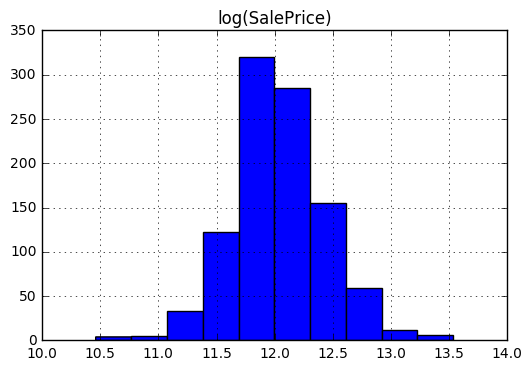

In [55]:
# Check log transform - looks good
%matplotlib inline
train['SalePrice'].log().as_data_frame().hist()

# Execute log transform
train['SalePrice'] = train['SalePrice'].log()
valid['SalePrice'] = valid['SalePrice'].log()
print(train[0:3, 'SalePrice'])

#### Define ranked predictions plot function

In [56]:
def ranked_preds_plot(y, valid, model):
    
    """ Generates ranked prediction plot.
    
    :param y: Name of target variable.
    :param valid: Name of validation H2OFrame.
    :param model: Model from which to generate predictions to plot.

    """
    
    # plot top frame values
    yhat_frame = valid.cbind(model.predict(valid))
    print(yhat_frame[0:10, [y, 'predict']])

    # plot sorted predictions
    yhat_frame_df = yhat_frame[[y, 'predict']].as_data_frame()
    yhat_frame_df.sort_values(by='predict', inplace=True)
    yhat_frame_df.reset_index(inplace=True, drop=True)
    _ = yhat_frame_df.plot(title='Ranked Predictions Plot')


#### Function to generate submission file

In [57]:
import re
import time

def gen_submission(model, test=test):

    """ Generates submission file for Kaggle House Prices contest.
    
    :param model: Model with which to score test data.
    :param test: Test data.
    
    """
    
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())

    # create predictions column
    sub = test['Id'].cbind(model.predict(test).exp())
    sub.columns = ['Id', 'SalePrice']
    
    # save file for submission
    sub_fname = '../data/submission_' + str(time_stamp) + '.csv'
    h2o.download_csv(sub, sub_fname)


#### Split training data

In [58]:
half_train, other_half_train = train.split_frame([0.5], seed=12345)
half_valid, other_half_valid = valid.split_frame([0.5], seed=12345)
print(half_train.shape)
print(half_valid.shape)
print(other_half_train.shape)
print(other_half_valid.shape)

(504, 3205)
(230, 3205)
(497, 3205)
(229, 3205)


#### Linear model (already submitted in section 03)

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.01]  Grid_GLM_py_630_sid_9a65_model_python_1497211562086_1_model_0   
1    [0.25]  Grid_GLM_py_630_sid_9a65_model_python_1497211562086_1_model_1   
2     [0.5]  Grid_GLM_py_630_sid_9a65_model_python_1497211562086_1_model_2   
3    [0.75]  Grid_GLM_py_630_sid_9a65_model_python_1497211562086_1_model_3   
4    [0.99]  Grid_GLM_py_630_sid_9a65_model_python_1497211562086_1_model_4   

    residual_deviance  
0   3.371896736365861  
1  3.5629210729316814  
2   3.571171553122266  
3  3.7673610205588943  
4   3.768915251376547  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_630_sid_9a65_model_python_1497211562086_1_model_0


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.013198403927250633
RMSE: 0.1148843067057056
MAE: 0.08201776947877121
RMSLE: 0.008

,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-06-11 16:07:57,0.000 sec,0,.32E2,29,0.1539906,0.1482910
,2017-06-11 16:07:57,0.075 sec,0,.3E2,36,0.1490545,0.1437252
,2017-06-11 16:07:57,0.170 sec,0,.29E2,61,0.1432811,0.1384604
,2017-06-11 16:07:57,0.203 sec,0,.27E2,95,0.1363604,0.1322562
,2017-06-11 16:07:57,0.232 sec,0,.26E2,114,0.1291709,0.1258363
---,---,---,---,---,---,---,---
,2017-06-11 16:08:08,11.700 sec,0,.4E0,693,0.0123079,0.0157636
,2017-06-11 16:08:09,11.942 sec,0,.38E0,690,0.0121844,0.0160634
,2017-06-11 16:08:09,12.183 sec,0,.36E0,678,0.0120575,0.0163854
,2017-06-11 16:08:09,12.446 sec,0,.35E0,672,0.0119441,0.0167540



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.8494,12.0926
12.2061,12.1947
11.6784,11.8053
11.914,11.7906
12.6758,12.4599
12.861,12.6627
12.1035,11.9512
11.2898,11.378
11.7714,11.6659
11.5843,11.5337


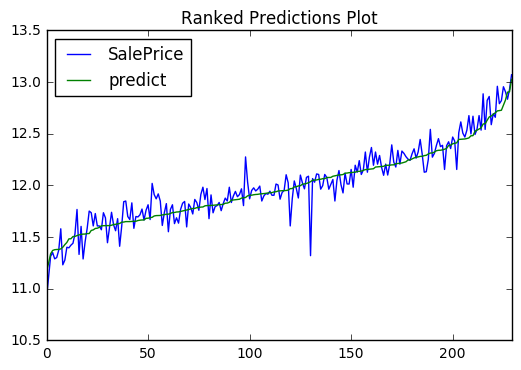

In [60]:
alpha_opts = [0.01, 0.25, 0.5, 0.75, 0.99] # always keep some L2
hyper_parameters = {"alpha":alpha_opts}

# initialize grid search
grid = H2OGridSearch(
    H2OGeneralizedLinearEstimator(
        family="gaussian",
        lambda_search=True,
        seed=12345),
        hyper_params=hyper_parameters)
   
# train grid
grid.train(y='SalePrice',
           x=encoded_combined_nums, 
           training_frame=half_train,
           validation_frame=half_valid)

# show grid search results
print(grid.show())

best_glm = grid.get_grid()[0]
print(best_glm)
ranked_preds_plot('SalePrice', half_valid, best_glm)

#### Use GLM for feature selection

In [67]:
glm_selected_nums = []
for key in best_glm.coef():
    if best_glm.coef()[key] != 0.0 and key != 'Intercept':
        glm_selected_nums.append(key)

#### MLP model 

deeplearning Grid Build progress: |███████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.01]  Grid_GLM_py_630_sid_9a65_model_python_1497211562086_1_model_0   
1    [0.25]  Grid_GLM_py_630_sid_9a65_model_python_1497211562086_1_model_1   
2     [0.5]  Grid_GLM_py_630_sid_9a65_model_python_1497211562086_1_model_2   
3    [0.75]  Grid_GLM_py_630_sid_9a65_model_python_1497211562086_1_model_3   
4    [0.99]  Grid_GLM_py_630_sid_9a65_model_python_1497211562086_1_model_4   

    residual_deviance  
0   3.371896736365861  
1  3.5629210729316814  
2   3.571171553122266  
3  3.7673610205588943  
4   3.768915251376547  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_630_sid_9a65_model_python_1497211562086_1_model_0


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.013198403927250633
RMSE: 0.1148843067057056
MAE: 0.08201776947877121
RMSLE: 0.008

,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-06-11 16:07:57,0.000 sec,0,.32E2,29,0.1539906,0.1482910
,2017-06-11 16:07:57,0.075 sec,0,.3E2,36,0.1490545,0.1437252
,2017-06-11 16:07:57,0.170 sec,0,.29E2,61,0.1432811,0.1384604
,2017-06-11 16:07:57,0.203 sec,0,.27E2,95,0.1363604,0.1322562
,2017-06-11 16:07:57,0.232 sec,0,.26E2,114,0.1291709,0.1258363
---,---,---,---,---,---,---,---
,2017-06-11 16:08:08,11.700 sec,0,.4E0,693,0.0123079,0.0157636
,2017-06-11 16:08:09,11.942 sec,0,.38E0,690,0.0121844,0.0160634
,2017-06-11 16:08:09,12.183 sec,0,.36E0,678,0.0120575,0.0163854
,2017-06-11 16:08:09,12.446 sec,0,.35E0,672,0.0119441,0.0167540



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.8494,12.0926
12.2061,12.1947
11.6784,11.8053
11.914,11.7906
12.6758,12.4599
12.861,12.6627
12.1035,11.9512
11.2898,11.378
11.7714,11.6659
11.5843,11.5337



glm prediction progress: |████████████████████████████████████████████████| 100%


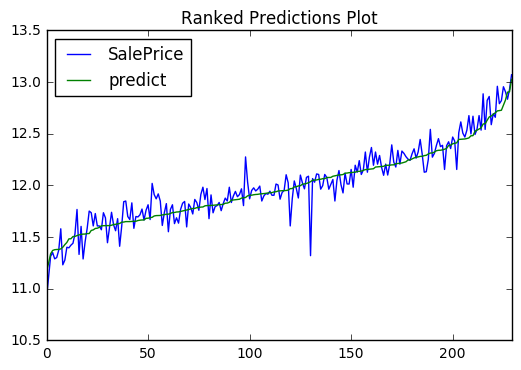

In [71]:
# define random grid search parameters
hyper_parameters = {'hidden': [[1000], [500, 500], [250, 250, 250, 250], [1000, 500], [500, 1000], [1000, 500, 250], [1000, 1000]],
                    'l1':[s/1e4 for s in range(0, 1000, 100)],
                    'l2':[s/1e5 for s in range(0, 1000, 100)],
                    'input_dropout_ratio':[s/1e2 for s in range(0, 20, 2)]}

# define search strategy
search_criteria = {'strategy':'RandomDiscrete',
                   'max_models':100,
                   'max_runtime_secs':1200}

# initialize grid search
gsearch = H2OGridSearch(H2ODeepLearningEstimator,
                        hyper_params=hyper_parameters,
                        search_criteria=search_criteria)

# execute training w/ grid search
gsearch.train(x=glm_selected_nums,
              y='SalePrice',
              training_frame=half_train,
              validation_frame=half_valid,
              activation='Tanh', 
              epochs=1000, 
              stopping_rounds=5,                 
              ignore_const_cols=True,              
              adaptive_rate=True)

# show grid search results
print(grid.show())

best_nn = grid.get_grid()[0]
print(best_nn)
ranked_preds_plot('SalePrice', half_valid, best_nn)
gen_submission(best_nn) # Valid RMSE ~0.1210, public leaderboard ~

#### Random forest model - typically not tuned as much as GBM

drf Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1497211562086_4


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.019900053922654908
RMSE: 0.1410675509203123
MAE: 0.09696003082078246
RMSLE: 0.010990322332114407
Mean Residual Deviance: 0.019900053922654908

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.02206296297376914
RMSE: 0.14853606623904222
MAE: 0.10652289705509867
RMSLE: 0.01140423427499746
Mean Residual Deviance: 0.02206296297376914
Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2017-06-11 16:46:14,0.016 sec,0.0,nan,nan,nan,nan,nan,nan
,2017-06-11 16:46:14,0.469 sec,1.0,0.2263341,0.1685325,0.0512271,0.2298577,0.1677482,0.0528346
,2017-06-11 16:46:14,0.636 sec,2.0,0.2165760,0.1573064,0.0469052,0.2052531,0.1445884,0.0421288
,2017-06-11 16:46:14,0.807 sec,3.0,0.1987569,0.1464383,0.0395043,0.1857130,0.1330210,0.0344893
,2017-06-11 16:46:15,0.959 sec,4.0,0.1937970,0.1435045,0.0375573,0.1810585,0.1295014,0.0327822
---,---,---,---,---,---,---,---,---,---
,2017-06-11 16:46:50,36.471 sec,250.0,0.1411836,0.0975218,0.0199328,0.1483639,0.1060559,0.0220118
,2017-06-11 16:46:54,40.574 sec,278.0,0.1411866,0.0971124,0.0199337,0.1484179,0.1062814,0.0220279
,2017-06-11 16:46:58,44.590 sec,307.0,0.1412056,0.0971382,0.0199390,0.1486194,0.1065917,0.0220877
,2017-06-11 16:47:02,48.674 sec,336.0,0.1408507,0.0968954,0.0198389,0.1485569,0.1065743,0.0220691



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Neighborhood_Tencode|GrLivArea,5765.7587891,1.0,0.2461322
OverallQual|Neighborhood_Tencode,3224.0002441,0.5591632,0.1376281
LotShape_Tencode|OverallQual,2094.1999512,0.3632132,0.0893985
OverallQual|YearRemodAdd,1788.7630615,0.3102390,0.0763598
OverallQual|YearBuilt,927.9565430,0.1609427,0.0396132
---,---,---,---
3SsnPorch|EnclosedPorch,0.0043537,0.0000008,0.0000002
BsmtUnfSF|PoolArea,0.0041256,0.0000007,0.0000002
OpenPorchSF|PoolArea,0.0016967,0.0000003,0.0000001
MiscVal|2ndFlrSF,0.0009443,0.0000002,0.0000000



See the whole table with table.as_data_frame()

drf prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.8494,12.1404
12.2061,12.3218
11.6784,11.6806
11.914,11.7595
12.6758,12.5135
12.861,12.6362
12.1035,11.9698
11.2898,11.4536
11.7714,11.658
11.5843,11.615


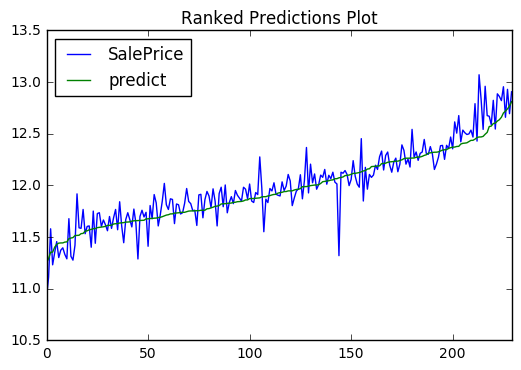

In [69]:
# initialize rf model
rf_model = H2ORandomForestEstimator(
    ntrees=1000,                     # Up to 1000 decision trees in the forest 
    max_depth=50,                    # trees can grow to depth of 30
    stopping_rounds=5)               # stop after validation error does not decrease for 5 iterations/new trees

# train rf model
rf_model.train(
    x=glm_selected_nums,
    y='SalePrice',
    training_frame=half_train,
    validation_frame=half_valid)

# print model information
print(rf_model)
ranked_preds_plot('SalePrice', half_valid, rf_model) # valid RMSE: 0.1415, not worth submitting 

#### Extremely random trees model - typically not tuned as much as GBM

drf Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1497134150670_5


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.02125492780213059
RMSE: 0.14579069861321947
MAE: 0.0963924219751856
RMSLE: 0.011351942006481508
Mean Residual Deviance: 0.02125492780213059

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.01977380474005669
RMSE: 0.14061936118492604
MAE: 0.10264988746438589
RMSLE: 0.010825544551452905
Mean Residual Deviance: 0.01977380474005669
Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2017-06-10 19:10:08,0.020 sec,0.0,nan,nan,nan,nan,nan,nan
,2017-06-10 19:10:10,1.350 sec,1.0,0.2084943,0.1501201,0.0434699,0.2353730,0.1621160,0.0554004
,2017-06-10 19:10:11,2.377 sec,2.0,0.2174953,0.1523578,0.0473042,0.1812903,0.1285753,0.0328662
,2017-06-10 19:10:12,3.429 sec,3.0,0.2101646,0.1458060,0.0441692,0.1600012,0.1143233,0.0256004
,2017-06-10 19:10:16,7.796 sec,7.0,0.1921095,0.1310902,0.0369061,0.1431625,0.1029586,0.0204955
---,---,---,---,---,---,---,---,---,---
,2017-06-10 19:11:18,1 min 9.251 sec,57.0,0.1458272,0.0965575,0.0212656,0.1414240,0.1027786,0.0200007
,2017-06-10 19:11:23,1 min 14.296 sec,61.0,0.1459152,0.0965090,0.0212912,0.1414856,0.1034397,0.0200182
,2017-06-10 19:11:28,1 min 19.458 sec,65.0,0.1457174,0.0964314,0.0212336,0.1410903,0.1033091,0.0199065
,2017-06-10 19:11:33,1 min 24.341 sec,69.0,0.1456138,0.0964021,0.0212034,0.1402541,0.1025219,0.0196712



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Neighborhood_Tencode|GrLivArea,1068.3203125,1.0,0.2281965
OverallQual|Neighborhood_Tencode,617.2948608,0.5778181,0.1318561
OverallQual|GrLivArea,401.4296265,0.3757577,0.0857466
LotShape_Tencode|OverallQual,352.5961304,0.3300472,0.0753156
BsmtQual_Tencode|GrLivArea,284.6484375,0.2664448,0.0608018
---,---,---,---
OverallCond|ScreenPorch,0.0,0.0,0.0
MSZoning_Tencode|Condition2_Tencode,0.0,0.0,0.0
BedroomAbvGr|ScreenPorch,0.0,0.0,0.0
EnclosedPorch|ScreenPorch,0.0,0.0,0.0



See the whole table with table.as_data_frame()

drf prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.8494,12.118
12.2061,12.3005
11.6784,11.6973
11.914,11.7504
12.6758,12.5472
12.861,12.6691
12.1035,11.9837
11.2898,11.4366
11.7714,11.6439
11.5843,11.5963


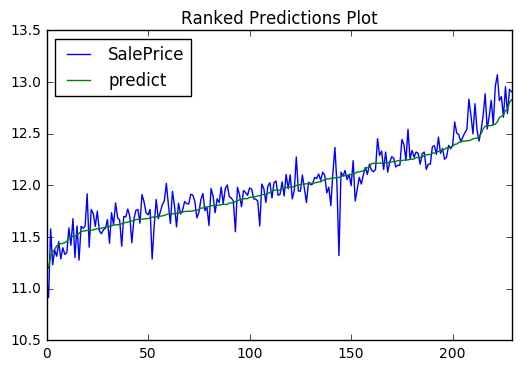

In [26]:
# initialize extra trees model
ert_model = H2ORandomForestEstimator(
    ntrees=1000,                     # Up to 1000 decision trees in the forest 
    max_depth=50,                    # trees can grow to depth of 30
    stopping_rounds=5,               # stop after validation error does not decrease for 5 iterations/new trees
    histogram_type='random')         # <- this is what makes it ERT instead of RF

# train rf model
ert_model.train(
    x=encoded_combined_nums,
    y='SalePrice',
    training_frame=base_train,
    validation_frame=base_valid)

# print model information
print(ert_model)
ranked_preds_plot('SalePrice', base_valid, ert_model) # Valid RMSE: 0.1406, not worth submitting 

#### GBM model

gbm Grid Build progress: |████████████████████████████████████████████████| 100%
     col_sample_rate max_depth ntrees sample_rate  \
0                0.2        13     73         0.9   
1                0.3         2    287         0.4   
2                0.7         1    153         0.2   
3                1.0        17    384         0.8   
4                0.2        11    497         0.2   
5                0.2         6    385         0.8   
6                0.4        16    220         0.5   
7                0.6        16    214         0.7   
8                0.2         7     30         0.4   
9                0.2        17    172         0.8   
10               0.8        15     76         0.3   
11               0.3         6    152         0.7   
12               0.6        18    361         0.6   
13               0.6         3    169         0.1   
14               0.8         9    204         0.4   
15               0.4         8    407         0.4   
16               0

,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2017-06-10 19:13:08,16.030 sec,0.0,0.3957607,0.3067213,0.1566265,0.3882444,0.3091897,0.1507337
,2017-06-10 19:13:08,16.242 sec,1.0,0.3604369,0.2776850,0.1299148,0.3563362,0.2805511,0.1269755
,2017-06-10 19:13:08,16.496 sec,2.0,0.3281715,0.2515401,0.1076965,0.3270407,0.2537847,0.1069556
,2017-06-10 19:13:08,16.709 sec,3.0,0.2992394,0.2279365,0.0895442,0.3029306,0.2316414,0.0917669
,2017-06-10 19:13:08,16.939 sec,4.0,0.2733349,0.2067814,0.0747120,0.2823326,0.2140459,0.0797117
---,---,---,---,---,---,---,---,---,---
,2017-06-10 19:13:11,19.495 sec,16.0,0.1079724,0.0708088,0.0116580,0.1627841,0.1154685,0.0264987
,2017-06-10 19:13:11,19.718 sec,17.0,0.1015141,0.0655518,0.0103051,0.1589424,0.1128442,0.0252627
,2017-06-10 19:13:11,19.903 sec,18.0,0.0955731,0.0607227,0.0091342,0.1563452,0.1109142,0.0244438
,2017-06-10 19:13:15,23.927 sec,44.0,0.0420033,0.0209760,0.0017643,0.1399507,0.0999064,0.0195862



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Neighborhood_Tencode|GrLivArea,55.3546562,1.0,0.1392508
OverallQual|GrLivArea,52.2542381,0.9439899,0.1314514
OverallQual|YearRemodAdd,30.2223797,0.5459772,0.0760278
LotShape_Tencode|OverallQual,28.8121662,0.5205012,0.0724802
BsmtQual_Tencode|GrLivArea,26.7864475,0.4839060,0.0673843
---,---,---,---
GarageQual_Tencode|Condition1_Tencode,0.0,0.0,0.0
GarageQual_Tencode|BsmtFullBath,0.0,0.0,0.0
GarageQual_Tencode|Condition2_Tencode,0.0,0.0,0.0
Condition1_Tencode|Condition2_Tencode,0.0,0.0,0.0



See the whole table with table.as_data_frame()

gbm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.8494,12.1293
12.2061,12.2943
11.6784,11.7289
11.914,11.7166
12.6758,12.5435
12.861,12.7504
12.1035,11.9359
11.2898,11.4073
11.7714,11.6112
11.5843,11.6131


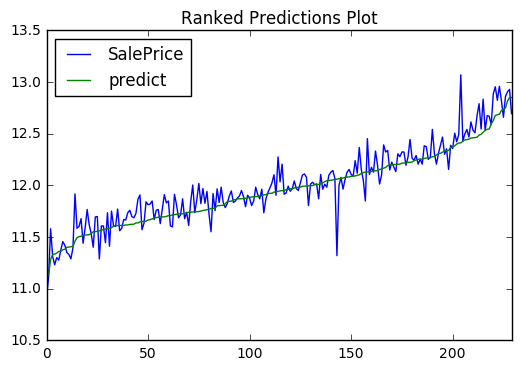

In [27]:
# define random grid search parameters
hyper_parameters = {'ntrees':list(range(1, 500)),
                    'max_depth':list(range(1, 20)),
                    'sample_rate':[s/float(10) for s in range(1, 11)],
                    'col_sample_rate':[s/float(10) for s in range(1, 11)]}

# define search strategy
search_criteria = {'strategy':'RandomDiscrete',
                   'max_models':100,
                   'max_runtime_secs':1200}

# initialize grid search
grid = H2OGridSearch(H2OGradientBoostingEstimator,
                     hyper_params=hyper_parameters,
                     search_criteria=search_criteria)

# execute training w/ grid search
grid.train(x=encoded_combined_nums,
           y='SalePrice',
           training_frame=base_train,
           validation_frame=base_valid)

# show grid search results
print(grid.show())

best_gbm = grid.get_grid()[0]
print(best_gbm)
ranked_preds_plot('SalePrice', base_valid, best_gbm) # Valid RMSE: 0.1397, not worth submitting 

#### Shurdown H2O

In [37]:
# Shutdown H2O - this will erase all your unsaved frames and models in H2O
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://localhost:54321 (Y/N)? y
H2O session _sid_8d49 closed.
